In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys

sys.path.append('..')

from benchmark.himmelblau import Himmelblau
from benchmark.holder import Holder
from benchmark.rosenbrock import Rosenbrock
from benchmark.levy import Levy

from optims.BayesOpt import BayesOpt
from optims.AdaLIPO_E import AdaLIPO_E
from optims.SBS import SBS
from optims.N_CMA_ES import CMA_ES

/home/gserre/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def create_bounds(min, max, dim):
    bounds = [(min, max) for _ in range(dim)]
    return np.array(bounds)

In [5]:
def time_it (func, *args):
    import time
    start = time.time()
    res = func(*args)
    end = time.time()
    return res, end-start

In [6]:
fs = {
  "Himmelblau": [Himmelblau(), create_bounds(-4, 4, 2)],
  #"Holder Table": [Holder(), create_bounds(-10, 10, 2)],
  "Levy": [Levy(), create_bounds(-10, 10, 2)],
  #"Rosenbrock": [Rosenbrock(), create_bounds(-3, 3, 2)],
}

In [7]:
evals = np.linspace(5, 150, 10, dtype=int)

bayes_results = {}
bayes_times = {}

for f_name in tqdm(fs.keys()):
  h = fs[f_name][0]
  bounds = fs[f_name][1]

  bayes_results_tmp = []
  bayes_times_tmp = []
  for num_evals in evals:
    bayes = BayesOpt(bounds, n_iter=num_evals)
    res, time = time_it(bayes.optimize, h)
    opt = res[0][1]
    bayes_results_tmp.append(np.abs(h.min - opt))
    bayes_times_tmp.append(time)
    
  bayes_results[f_name] = bayes_results_tmp
  bayes_times[f_name] = bayes_times_tmp


100%|██████████| 2/2 [03:06<00:00, 93.45s/it] 


In [ ]:
for f_name in fs.keys():
  plt.plot(evals, bayes_results[f_name])
  plt.yscale("log")
  plt.xlabel("Number of evaluations")
  plt.ylabel("log distance to minimum")
  plt.title(f"Convergence of BayesOpt on {f_name}")
  plt.savefig(f"fig/perf/perf_vs_evals_bayes_{f_name}.png", bbox_inches="tight", dpi=300)
  plt.clf()

<Figure size 640x480 with 0 Axes>

In [ ]:
for f_name in fs.keys():
  plt.plot(evals, bayes_times[f_name])
  plt.xlabel("Number of evaluations")
  plt.ylabel("time (s)")
  plt.title(f"Time taken by BayesOpt on {f_name}")
  plt.savefig(f"fig/time/time_vs_evals_bayes_{f_name}.png", bbox_inches="tight", dpi=300)
  plt.clf()

<Figure size 640x480 with 0 Axes>

In [8]:
evals = np.linspace(5, 2000, 10, dtype=int)

ada_results = {}
ada_times = {}

for f_name in tqdm(fs.keys()):
  h = fs[f_name][0]
  bounds = fs[f_name][1]

  ada_results_tmp = []
  ada_times_tmp = []
  for num_evals in evals:
    ada = AdaLIPO_E(bounds, max_evals=num_evals)
    res, time = time_it(ada.optimize, h)
    opt = res[0][1]
    ada_results_tmp.append(np.abs(h.min - opt))
    ada_times_tmp.append(time)
    
  ada_results[f_name] = ada_results_tmp
  ada_times[f_name] = ada_times_tmp


100%|██████████| 2/2 [02:06<00:00, 63.10s/it]


In [ ]:
for f_name in fs.keys():
  plt.plot(evals, ada_results[f_name])
  plt.yscale("log")
  plt.xlabel("Number of evaluations")
  plt.ylabel("log distance to minimum")
  plt.title(f"Convergence of AdaLIPO on {f_name}")
  plt.savefig(f"fig/perf/perf_vs_evals_ada_{f_name}.png", bbox_inches="tight", dpi=300)
  plt.clf()

<Figure size 640x480 with 0 Axes>

In [ ]:
for f_name in fs.keys():
  plt.plot(evals, ada_times[f_name])
  plt.xlabel("Number of evaluations")
  plt.ylabel("time (s)")
  plt.title(f"Time taken by AdaLIPO on {f_name}")
  plt.savefig(f"fig/time/time_vs_evals_ada_{f_name}.png", bbox_inches="tight", dpi=300)
  plt.clf()

<Figure size 640x480 with 0 Axes>

In [9]:
evals = np.linspace(5, 2000, 10, dtype=int)

cma_results = {}
cma_times = {}

for f_name in tqdm(fs.keys()):
  h = fs[f_name][0]
  bounds = fs[f_name][1]

  cma_results_tmp = []
  cma_times_tmp = []
  for num_evals in evals:
    m_0 = np.random.uniform(bounds[:, 0], bounds[:, 1])
    cma = CMA_ES(bounds, m_0, max_evals=num_evals)
    res, time = time_it(cma.optimize, h)
    opt = res[0][1]
    cma_results_tmp.append(np.abs(h.min - opt))
    cma_times_tmp.append(time)
    
  cma_results[f_name] = cma_results_tmp
  cma_times[f_name] = cma_times_tmp


100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


In [10]:
def eval_to_sbs_params(n_eval):
  if n_eval < 10:
    return (1, 10)
  elif n_eval // 10 <= 100:
    return (n_eval // 10, 10)
  else:
    return (100, n_eval // 100)

def sbs_(bounds, n_eval):
  n, m = eval_to_sbs_params(n_eval)
  sbs = SBS(bounds, n, [10_000], m)
  return sbs


In [11]:
evals = np.linspace(5, 2000, 10, dtype=int)

sbs_results = {}
sbs_times = {}

for f_name in tqdm(fs.keys()):
  h = fs[f_name][0]
  bounds = fs[f_name][1]

  sbs_results_tmp = []
  sbs_times_tmp = []
  for num_evals in evals:
    sbs = sbs_(bounds, num_evals)
    res, time = time_it(sbs.optimize, h)
    opt = res[0][1]
    sbs_results_tmp.append(np.abs(h.min - opt))
    sbs_times_tmp.append(time)
    
  sbs_results[f_name] = sbs_results_tmp
  sbs_times[f_name] = sbs_times_tmp

100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


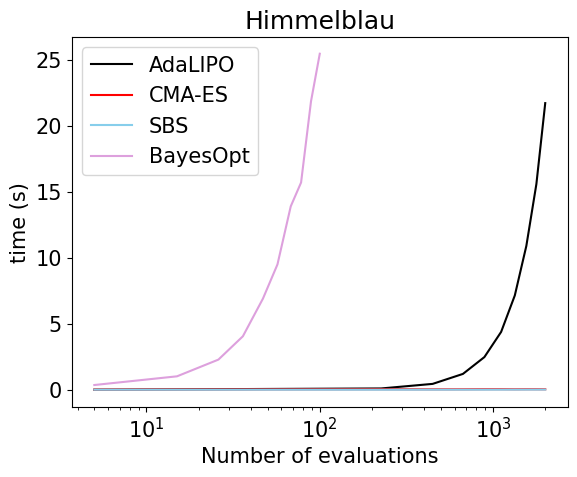

In [ ]:
evals = np.linspace(5, 2000, 10, dtype=int)
plt.rcParams.update({'font.size': 15})
plt.semilogx(evals, ada_times["Himmelblau"], c="black", label="AdaLIPO")
plt.semilogx(evals, cma_times["Himmelblau"], c="red", label="CMA-ES")
plt.semilogx(evals, sbs_times["Himmelblau"], c="skyblue", label="SBS")
evals = np.linspace(5, 100, 10, dtype=int)
plt.semilogx(evals, bayes_times["Himmelblau"], c="plum", label="BayesOpt")
plt.xlabel("Number of evaluations (log scale)")
plt.ylabel("time (s)")
plt.title(f"Himmelblau")
plt.legend()
plt.savefig("time_vs_evals_Himmelblau.pdf", bbox_inches="tight")

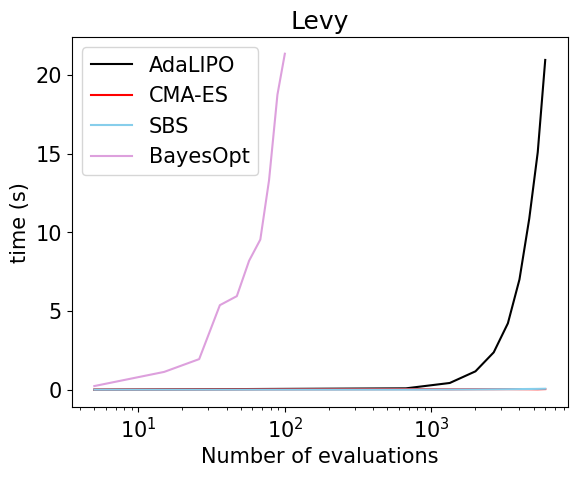

In [ ]:
evals = np.linspace(5, 6000, 10, dtype=int)
plt.rcParams.update({'font.size': 15})
plt.semilogx(evals, ada_times["Levy"], c="black", label="AdaLIPO")
plt.semilogx(evals, cma_times["Levy"], c="red", label="CMA-ES")
plt.semilogx(evals, sbs_times["Levy"], c="skyblue", label="SBS")
evals = np.linspace(5, 100, 10, dtype=int)
plt.semilogx(evals, bayes_times["Levy"], c="plum", label="BayesOpt")
plt.xlabel("Number of evaluations (log scale)")
plt.ylabel("time (s)")
plt.title(f"Levy")
plt.legend()
plt.savefig("time_vs_evals_Levy.pdf", bbox_inches="tight")

In [ ]:
evals = np.linspace(300, 1_000_000, 10, dtype=int)

sbs_times = {}

for f_name in tqdm(fs.keys()):
  h = fs[f_name][0]
  bounds = fs[f_name][1]

  sbs_times_tmp = []
  for num_evals in evals:
    svgd_iter = 300
    n_particles = max(num_evals // (300 * 3), 1)
    sbs = SBS(
      bounds,
      n_particles=n_particles,
      k_iter=[10_000],
      svgd_iter=svgd_iter,
      sigma=1 / n_particles**2,
      lr=0.2
    )
    res, time = time_it(sbs.optimize, h)
    sbs_times_tmp.append(time)
    
  sbs_times[f_name] = sbs_times_tmp


100%|██████████| 2/2 [01:24<00:00, 42.47s/it]


In [ ]:
for f_name in fs.keys():
  plt.plot(evals, sbs_times[f_name])
  plt.xlabel("Number of evaluations")
  plt.ylabel("time (s)")
  plt.title(f"Time taken by SBS on {f_name}")
  plt.savefig(f"fig/time/time_vs_evals_sbs_{f_name}.png", bbox_inches="tight", dpi=300)
  plt.clf()

<Figure size 640x480 with 0 Axes>